In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../future_of_food/NDNS UK/ndns_edited.csv')
products = get_products('../../future_of_food/foodDB_23June/products.csv')
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../future_of_food/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6453
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Savoury Snack                               7
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Miscellaneous'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Miscellaneous')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(27598, 11)

In [12]:
lab.shape

(5618, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Savoury sauces pickles gravies & condiments    3817
Soup                                           1393
Beverages dry weight                            273
Nutrition powders and drinks                    135
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Miscellaneous    5618
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Savoury sauces pickles gravies & condiments                  3812
Soup                                                         1391
Beverages dry weight                                          273
Nutrition powders and drinks                                  135
Other milk                                                     19
Non-nutrient supplements (including herbal)                    18
Other chicken and turkey                                       16
Crisps and savoury snacks                                      12
Bottled water still or carbonated                              11
Tomatoes                                                       10
Other vegetable products and dishes                            10
Pasta                                                          10
Other vegetables                                                8
Pizza                                                           8
Other white fish                                                8
Other frie

In [16]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Miscellaneous'
lev2_labels_add['subfoodgroupdesc'] = np.NaN


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spirulina powder")),
                    'subfoodgroupdesc'] = 'Nutrition powders and drinks'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("recovery powder")),
                    'subfoodgroupdesc'] = 'Nutrition powders and drinks'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("for goodness")),
                    'subfoodgroupdesc'] = 'Nutrition powders and drinks'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vanilla extract")),
                    'subfoodgroupdesc'] = 'Savoury sauces pickles gravies & condiments'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("nutritional yeast")),
                    'subfoodgroupdesc'] = 'Savoury sauces pickles gravies & condiments'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [17]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("nutritional yeast"))
#                    ]

In [18]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [19]:
lab.shape

(5718, 12)

In [20]:
lab['subfoodgroupdesc'].value_counts()

Savoury sauces pickles gravies & condiments    3847
Soup                                           1393
Beverages dry weight                            273
Nutrition powders and drinks                    205
Name: subfoodgroupdesc, dtype: int64

In [21]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [22]:
query_embeddings = np.load('../../future_of_food/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../future_of_food/bert/tsne_results_all3.npy')
product_ids = np.load('../../future_of_food/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [23]:
for i in range(1):
    train, test = train_test_split(lab, test_size=0.1, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=20,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    

Number of unique level 1 categories in train: 1
Number of unique level 1 categories in test: 1
Number of unique level 2 categories in train: 4
Number of unique level 2 categories in test: 4

Lev 1 train accuracy: 1.0
Lev 1 train balanced accuracy: 1.0
Lev 1 test accuracy: 1.0
Lev 1 test balanced accuracy: 1.0

Lev 2 train accuracy: 0.9959191605130199
Lev 2 train balanced accuracy: 0.9958200636942676
Lev 2 test accuracy: 0.9877622377622378
Lev 2 test balanced accuracy: 0.9872262773722628

Number of unique level 1 categories predicted in train: 1
Number of unique level 1 categories predicted in test: 1
Number of unique level 2 categories predicted in train: 4
Number of unique level 2 categories predicted in test: 4



In [24]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=500, 
                             min_samples_leaf=10, 
                             max_depth=20,
                             class_weight='balanced'
                            )

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9965022735222105
Lev 2 train balanced accuracy: 0.9965251076206164
Number of unique level 2 categories in train: 4
Number of unique level 2 categories in pred: 4
(19, 13)


In [25]:
pred['subfoodgroup_pred'].value_counts()

Savoury sauces pickles gravies & condiments    22799
Soup                                            3590
Beverages dry weight                             682
Nutrition powders and drinks                     527
Name: subfoodgroup_pred, dtype: int64

In [26]:
# should stock and broth be in soup or in savoury sauces? stock is in savoury sauces and broth is in soup
# do pickles belong here or in vegetables?

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [28]:
# pred[pred['subfoodgroup_pred']=='Nutrition powders and drinks'].sample(100).sort_values(by='product_list_name').reset_index(drop=True)

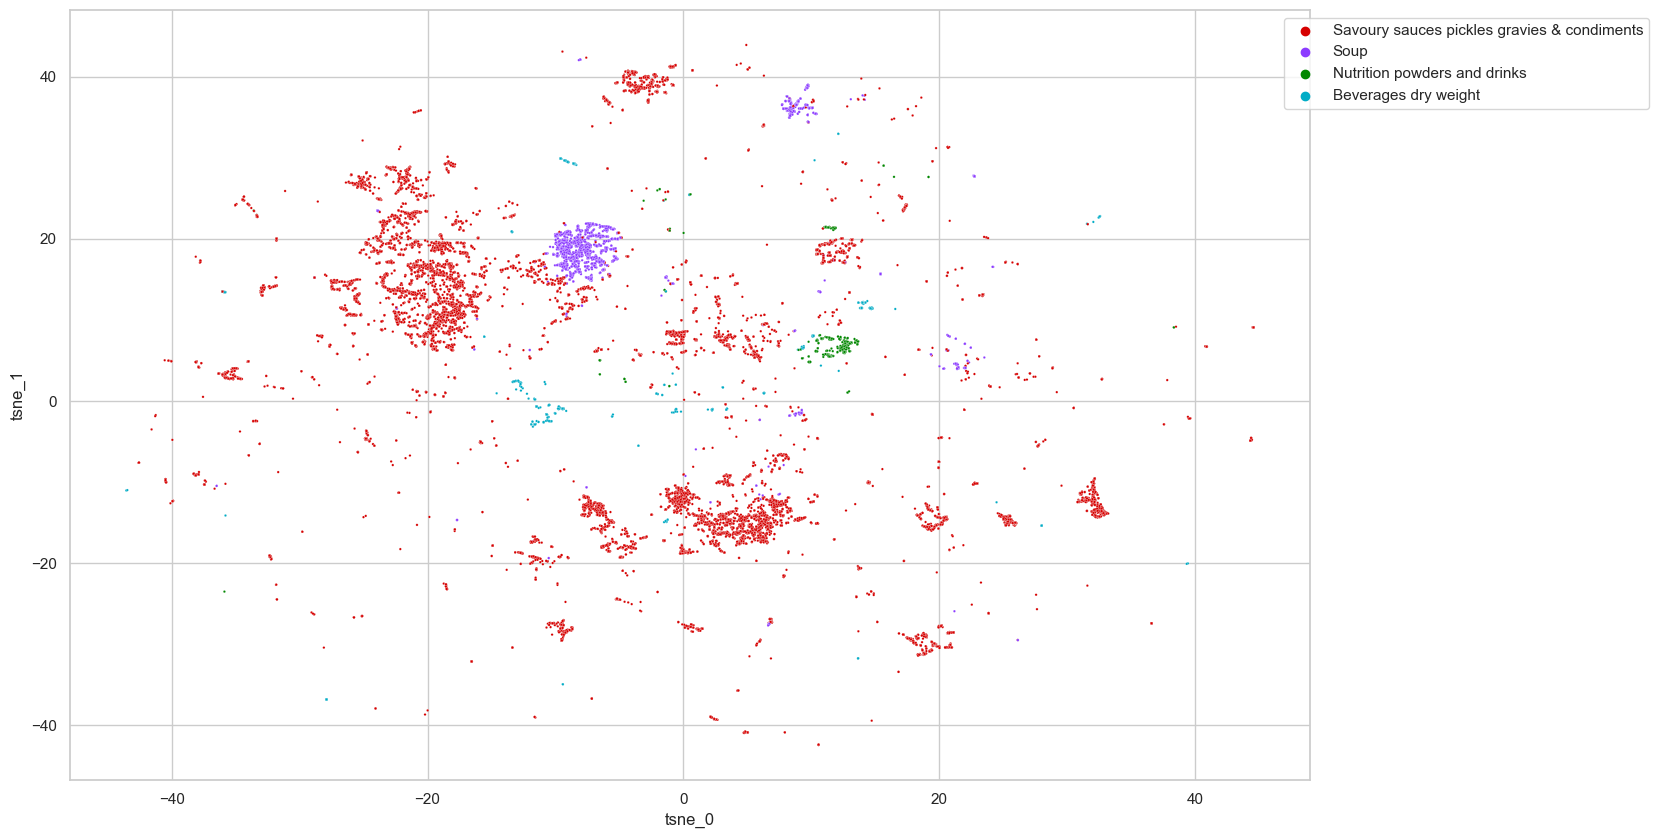

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [30]:
# save level 2 cereal categories
pred.to_csv('../../future_of_food/NDNS UK/predictions/predictions_misc_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)